In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
from tensorflow.keras import layers
import spektral
import os
import scipy.sparse as sp
import time

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 304312094940253297
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22718447616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3564424245336410427
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [3]:
samples = 20000
nLabel = 2
level = 95

# Spektral
# Define Graphs_Data class as a container for all graph files
class Graphs_Data(spektral.data.dataset.Dataset):
    def read(self):
        output = []
        path = 'GNN_Graph'
        # Load data from npz files into read()
        for i in range(samples):
            graph = np.load(os.path.join(path, f'GNN_{i}.npz'))
            output.append(spektral.data.dataset.Graph(x=graph['x'], e=graph['e'], y=spektral.utils.one_hot(graph['y']-1,nLabel))) 
            #            #, a=sp.csr_matrix(graph['a'])
            # y=spektral.utils.one_hot(graph['y']-1,3)
            # y=np.expand_dims(graph['y'],axis = -1)

        return output

In [4]:
# Load Data
GNN_Data = Graphs_Data()
bus = GNN_Data[0].n_nodes

C:\ProgramData\Anaconda3\lib\site-packages\spektral\data\dataset.py:120: UserWarning: The graphs in this dataset have no adjacency matrix. Is this intentional?
  warnings.warn(


In [5]:
# Creade adjacency matrix for MixedLoader dataset
Bra_data = loadtxt('BranchData.dat')
branch = Bra_data.shape[0]
AM = sp.csr_matrix((np.ones(branch), (Bra_data[:,2]-1, Bra_data[:,3]-1)), shape = [bus,bus])# + sp.csr_matrix((np.ones(branch), (Bra_data[:,3]-1, Bra_data[:,2]-1)), shape = [bus,bus])
GNN_Data.a = AM

In [6]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D, PReLU
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


from spektral.data import Dataset, Graph, MixedLoader, DisjointLoader, BatchLoader, PackedBatchLoader
from spektral.layers import XENetConv, DiffPool, SortPool
from spektral.transforms.normalize_adj import NormalizeAdj


data = GNN_Data

################################################################################
# Config
################################################################################
learning_rate = 0.001  # Learning rate
epochs = 250  # Number of training epochs
es_patience = 100  # Patience for early stopping
batch_size = 250  # Batch size

################################################################################
# Build model
################################################################################
class GNN(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = XENetConv(7, 12,  12     ,  node_activation="PReLU", edge_activation="PReLU")
        # self.conv2 = XENetConv(7, 24,  24     ,  node_activation="PReLU", edge_activation="PReLU")
        # self.conv3 = XENetConv(7, 80,  48     ,  node_activation="PReLU", edge_activation="PReLU")
        # self.conv4 = XENetConv(7, bus, bus,  node_activation="PReLU", edge_activation="PReLU")
        # self.conv5 = Conv1D(16, 1, activation='relu')
        # self.pool  = SortPool(branch)
        # self.drop  = Dropout(0.15)
        # self.act1  = PReLU()
        # self.act2  = PReLU()
        # self.act3  = PReLU()
        # self.act4  = PReLU()
        # self.act5  = PReLU()
        # self.act6  = PReLU()
        # self.act7  = PReLU()
        # self.act8  = PReLU()
        
        self.dense = Dense(data.n_labels, activation="softmax")



    def call(self, inputs, labels):
        x, a, e = inputs        
        x, e = self.conv1([x, a, e])
        # x    = self.act1(x)
        # e    = self.act2(e)
        
        # x, e = self.conv2([x, a, e])
        # x    = self.act3(x)
        # e    = self.act4(e)
        
        # x, e = self.conv3([x, a, e])
        # x    = self.act5(x)
        # e    = self.act6(e)
        
#         x, e = self.conv4([x, a, e])
        # x    = self.act7(x)
        # e    = self.act8(e)
        x_t = tf.gather(x, indices = a.indices[:,0].numpy(), axis = 1)
        x_f = tf.gather(x, indices = a.indices[:,1].numpy(), axis = 1)
        output = self.dense(e  + x_t + x_f)  # + np.transpose(x,(0,2,1)))
        return output, labels


model = GNN()
optimizer = Adam(learning_rate=learning_rate)
# optimizer = SGD(learning_rate=learning_rate, momentum=0.7, nesterov=False,name='SGD')
# loss_fn = CategoricalCrossentropy(reduction = tf.keras.losses.Reduction.NONE)
loss_fn = CategoricalCrossentropy()
################################################################################

In [7]:
# Train/valid/test split
idxs = range(len(data)) #np.random.permutation(len(data))
split_va, split_te = int(0.8 * len(data)), int(0.9 * len(data))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = data[idx_tr]
data_va = data[idx_va]
data_te = data[idx_te]


# Data loaders
loader_tr = MixedLoader(data_tr, batch_size=batch_size, epochs=epochs, shuffle = True)
loader_va = MixedLoader(data_va, batch_size=data_va.n_graphs, shuffle = True, epochs=1)
loader_te = MixedLoader(data_te, batch_size=data_te.n_graphs, shuffle = False, epochs=1)

In [8]:
# test_loader = BatchLoader(data_te, batch_size=data_te.n_graphs, shuffle = False, epochs=1)
# inputs, labels = test_loader.__next__() 

In [9]:
def evaluate(loader):
    for batch_va in loader:
        pred_va, targ_va = model(*batch_va, training=False)
        loss_va = loss_fn(targ_va, pred_va)
        acc_va = tf.reduce_mean(categorical_accuracy(targ_va, pred_va)),
    return loss_va, acc_va


# def evaluate1(loader):
#     inputs = loader.__next__()
    
#     return inputs

# X, Y = evaluate1(loader_va)   

In [10]:
epoch = step = 0
best_val_loss = np.inf
best_weights = None
patience = es_patience
results = []
step = 0
track = np.zeros([epochs,4])
start_t = time.time()

for batch in loader_tr:
    step += 1
    # loss, acc = train_step(*batch)
    
    with tf.GradientTape() as tape:
        prediction, target = model(*batch, training=True)
        # loss = loss_fn(target, prediction) + sum(model.losses)
        # test_loss = loss_fn(target, prediction)
        # print(test_loss)
        loss = loss_fn(target, prediction) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO) #UnconnectedGradients.NONE
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, prediction))
    results.append((loss, acc))
    
    #Print out result after every epoch
    if step == loader_tr.steps_per_epoch: 
        
        # Compute validation loss and accuracy
        loader_va = MixedLoader(data_va, batch_size=data_va.n_graphs, shuffle = True, epochs=1)
        val_loss, val_acc = evaluate(loader_va)
        
        #Save loss and accuracy for plotting
        track[epoch,:] = [ *np.mean(results, 0), val_loss.numpy(), val_acc[0].numpy() ]   
        
        step = 0
        epoch += 1        
        # Print out result for each epoch
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), val_loss.numpy(), val_acc[0].numpy() 
            )
        )
       
        # Check if loss improved for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(val_loss))
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
                break
        results = []

################################################################################
# Evaluate model
################################################################################
model.set_weights(best_weights)  # Load best model

stop_t = time.time()  

C:\ProgramData\Anaconda3\lib\site-packages\spektral\data\utils.py:206: UserWarning: `x` isn't a recognized object; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  shuffle_inplace(*data)


Ep. 1 - Loss: 70.06102 - Acc: 0.72550 - Val loss: 15.52413 - Val acc: 0.84314
New best val_loss 15.524
Ep. 2 - Loss: 9.45522 - Acc: 0.87902 - Val loss: 4.26112 - Val acc: 0.90828
New best val_loss 4.261
Ep. 3 - Loss: 1.05238 - Acc: 0.95223 - Val loss: 2.11236 - Val acc: 0.94388
New best val_loss 2.112
Ep. 4 - Loss: 0.57509 - Acc: 0.95827 - Val loss: 1.15741 - Val acc: 0.96156
New best val_loss 1.157
Ep. 5 - Loss: 0.37513 - Acc: 0.96068 - Val loss: 0.91770 - Val acc: 0.96252
New best val_loss 0.918
Ep. 6 - Loss: 0.32797 - Acc: 0.96099 - Val loss: 0.74817 - Val acc: 0.96198
New best val_loss 0.748
Ep. 7 - Loss: 0.27144 - Acc: 0.96111 - Val loss: 0.49421 - Val acc: 0.96183
New best val_loss 0.494
Ep. 8 - Loss: 0.19345 - Acc: 0.96088 - Val loss: 0.20247 - Val acc: 0.96101
New best val_loss 0.202
Ep. 9 - Loss: 0.15038 - Acc: 0.96123 - Val loss: 0.19526 - Val acc: 0.96108
New best val_loss 0.195
Ep. 10 - Loss: 0.14266 - Acc: 0.96139 - Val loss: 0.19343 - Val acc: 0.96131
New best val_loss 0.

In [11]:
#Round up the highest probability value to 1, all other probability values are set to 0
def max_prob(probability):
    prob = probability.numpy()
    max_val = np.amax(prob,2,keepdims=1)
    prob[prob != max_val] = 0
    prob[prob == max_val] = 1
    return prob

#Find the error rate of final prediction
def err_rate(preds,targs):
    diff_rate = targs - preds
    x, y, z = diff_rate.shape
    diff_rate[diff_rate == 1] = 0
    return np.sum(np.abs(diff_rate)) / (x * y)

# # Find which categories and which branches are misidentified the most for 3 categories
# def err_stat(preds,targs):
#     diff_rate = targs - preds
    
#     x, y, z = diff_rate.shape 
#     cat = np.array([ [1, -1, 0] , [1, 0, -1] , [0, 1, -1] , [-1, 1, 0] , [0, -1, 1] , [-1, 0, 1] ])
#     err = np.zeros([diff_rate.shape[0],diff_rate.shape[1],6])
#     for i in range(diff_rate.shape[0]): 
#         for j in range(diff_rate.shape[1]): 
#             for k in range(6):        
#                 err[i,j,k] = np.array_equiv(cat[k],diff_rate[i,j])
#     cat_stat = np.sum(np.sum(err,axis = 0),axis = 0)               #Error rate across 6 categories
#     bra_stat = np.sum(np.sum(err,axis = 0),axis = 1)               #Error rate across all branches
#     sam_stat = np.sum(np.sum(err,axis = 1),axis = 1)               #Error rate across number of samples
#     return cat_stat, bra_stat, sam_stat

# Find which categories and which branches are misidentified the most for 2 categories
def err_stat(preds,targs):
    diff_rate = targs - preds
    
    x, y, z = diff_rate.shape 
    cat = np.array([ [1, -1] , [-1, 1] ])
    err = np.zeros([x,y,2])
    for i in range(diff_rate.shape[0]): 
        for j in range(diff_rate.shape[1]): 
            for k in range(2):        
                err[i,j,k] = np.array_equiv(cat[k],diff_rate[i,j])
    cat_stat = np.sum(np.sum(err,axis = 0),axis = 0)               #Error rate across 6 categories
    
    sam_stat = np.sum(np.sum(err,axis = 1),axis = 1)               #Error rate across number of samples
    
    bra1_stat = np.sum(err[:,:,0],axis = 0)                        #Error rate across all branches for category 1
    bra2_stat = -np.sum(err[:,:,1],axis = 0)                       #Error rate across all branches for category 2
    return cat_stat, bra1_stat, bra2_stat, sam_stat, err

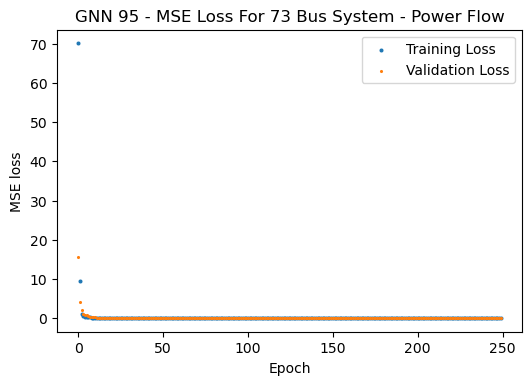

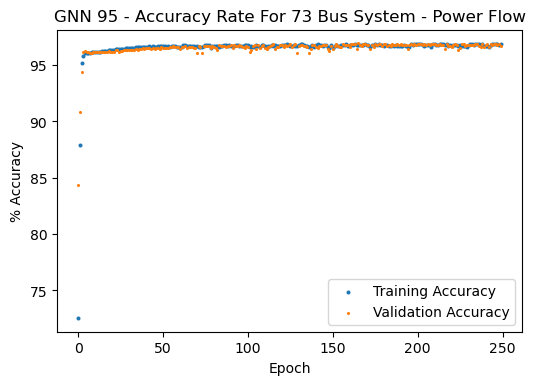

In [12]:
# Plot the result  
plt.figure(dpi=100)       
plt.scatter(range(epochs),track[:,0], label = "Training Loss", marker ="8", s = 4)
plt.scatter(range(epochs),track[:,2], label = "Validation Loss", marker = ".", s = 6)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('GNN {} - MSE Loss For {} Bus System - Power Flow'.format(level, bus))
plt.savefig("Plot/GNN_{}_Loss_{}.png".format(level, bus))

plt.figure(dpi=100) 
plt.scatter(range(epochs),track[:,1]*100, label = "Training Accuracy", marker ="8", s = 4)
plt.scatter(range(epochs),track[:,3]*100, label = "Validation Accuracy", marker = ".", s = 6)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Accuracy")
plt.title('GNN {} - Accuracy Rate For {} Bus System - Power Flow'.format(level, bus))
plt.savefig("Plot/GNN_{}_Accuracy_{}.png".format(level, bus))

In [13]:
#Evaluate the model against testing data set
loader_te = MixedLoader(data_te, batch_size=data_te.n_graphs, shuffle = False, epochs=1)
for batch in loader_te:
    test_prediction, test_target = model(*batch, training=False)

In [14]:
#Find the best probability of prediction for test data set:
pred = max_prob(test_prediction)
targ = tf.round(test_target).numpy()

[3475. 3030.]
[  0.   0.   0.   0.   0.   0. 230.   0.   0.   0.  78.   0.   0.   0.
   0.   0.   0.   0.   4.   0.   0.   0.   0.   0.   2.   0.   0.   0.
 511.   0.   0.   0.   0.   0. 717.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  59. 351.   0.
   0.   0.   0.   0.   0.   0.   0.  16.   0.   0.   0.   0.   0. 250.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 156. 248.   0.   0.   0.   0.   0.   0.   0.   0.  95.
   0.   0.   0.   0.   0. 758.   0.   0.   0.   0.]
[  -0.   -0.   -0.   -0.   -0.   -0. -207.   -0.   -0.   -0. -630.   -0.
   -0.   -0.   -0.   -0.   -0.  -37. -316.   -0.   -0.   -0.   -0.   -0.
   -0.   -0.   -0.   -0.  -76.   -0.   -0.   -0.   -0.   -0. -166.   -0.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
   -0.   -0.   -0.   -0.   -0.  -13.   -1.   -0.   -0.  -22.   -0.   -0.
   -0.  -86.   -0.   -0.   -0.   -0.   -0.   -0.   -0. -545.   -0.   -0.

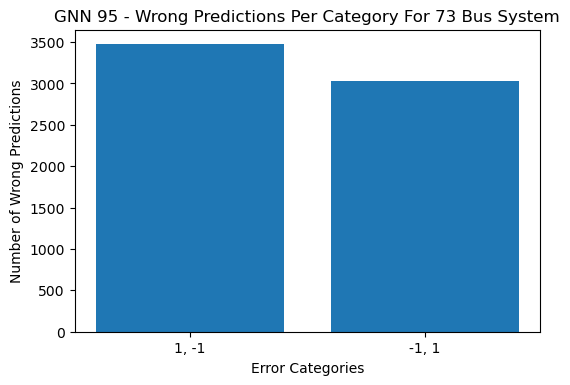

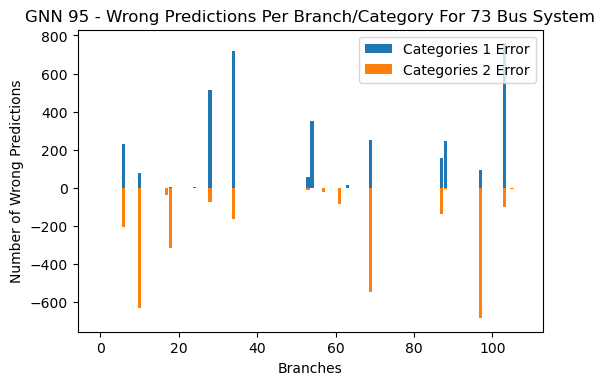

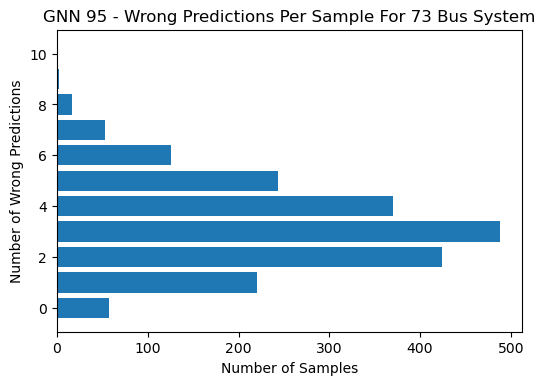

In [15]:
cat_err, bra1_err, bra2_err, sam_err, error = err_stat(pred, targ)

#Plot the number of wrong predictions per categories
# names = [ "1, -1, 0" , "1, 0, -1" , "0, 1, -1" , "-1, 1, 0" , "0, -1, 1" , "-1, 0, 1" ]
names = [ "1, -1" , "-1, 1"]
print(cat_err)
plt.figure(dpi=100)      
plt.bar(names, cat_err)
plt.xlabel('Error Categories')
plt.ylabel("Number of Wrong Predictions")
plt.title('GNN {} - Wrong Predictions Per Category For {} Bus System'.format(level, bus))
plt.savefig("Plot/GNN_{}_Categories_{}.png".format(level, bus))

#Plot the number of wrong predictions per branches
print(bra1_err)
print(bra2_err)
plt.figure(dpi=100) 
plt.bar(range(branch), bra1_err, label ="Categories 1 Error")
plt.bar(range(branch), bra2_err, label ="Categories 2 Error")
plt.legend()
plt.xlabel('Branches')
plt.ylabel("Number of Wrong Predictions")
plt.title('GNN {} - Wrong Predictions Per Branch/Category For {} Bus System'.format(level, bus))
plt.savefig("Plot/GNN_{}_Branches_{}.png".format(level, bus))

#Plot histogram of how many wrong predictions per number of samples
plt.figure(dpi=100) 
plt.hist(sam_err, bins = range(12), align = 'left', rwidth = 0.8, orientation = 'horizontal')
plt.xlabel("Number of Samples")
plt.ylabel("Number of Wrong Predictions")
plt.title('GNN {} - Wrong Predictions Per Sample For {} Bus System'.format(level, bus))
plt.savefig("Plot/GNN_{}_Historgram_{}.png".format(level, bus))

#Total number of wrong predictions and error rates
print('Number of wrong predictions is ', np.sum(cat_err))
print('Error rate is ', err_rate(pred, targ))

In [16]:
# #Write prediction result into .csv files
# pred_csv = pred
# pred_csv[:,:,0] = pred[:,:,0]*1
# pred_csv[:,:,1] = pred[:,:,1]*2
# # pred_csv[:,:,2] = pred[:,:,2]*3
# pred_csv = np.sum(pred_csv, axis = 2)


# with open(("Result/GNN_{}_PF_Predict_{}.csv".format(level, bus)), 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file, delimiter=',')
#     for i in range(pred_csv.shape[0]):
#         csv_writer.writerow(pred_csv[i,:])

In [17]:
#8 hidden layer 0.02658823529411765
#6 hidden layer 0.019073529411764704
#4 hidden layer 0.018808823529411763
#3 hidden layer 0.020191176470588237
#2 hidden layer 0.02514705882352941

In [18]:
#70 = 7 hidden layer 0.014680555555555556
#75 = 7 hidden layer 0.02226388888888889
#80 = 7 hidden layer 0.01851388888888889
#85 = 7 hidden layer 0.022574074074074073
#90 = 7 hidden layer 0.02325462962962963
#95 = 7 hidden layer 0.02287037037037037

In [20]:
stop_t - start_t


628.348090171814